# Merger Frequency Model

This notebook creates the merger frequency model.

## Steps

0. Configs
    - output dir
    - ansatz
    - fit parameters
1. loads NR data and defines train/test split
2. Fit ansatz to each sample
3. Parameter space fit
4. model validation
5. save model (GPs)

# Imports

In [104]:
import matplotlib
import matplotlib.pyplot as plt

plt.figure()
plt.show()
plt.close()
matplotlib.rcParams.update({"font.size": 16})

<Figure size 432x288 with 0 Axes>

In [105]:
import numpy as np
import os
import copy
import datetime
import pandas as pd
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

# gpr fitting
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF, ConstantKernel, RationalQuadratic, Matern, DotProduct

# i tried joblib and dill to save the model but they didn't work
# because under the hood i used a sympy lambdify function
# this SO post solved my issue using cloudpickle.
# https://stackoverflow.com/a/31365136/12840171
import cloudpickle

In [106]:
# custom
import phenom
import workflow_utils
import pn

import collocation

In [107]:
import sympy
# sympy.init_printing()
x_sym, a_sym, om_rd = sympy.symbols('x_sym a_sym om_rd')

# Config

In [108]:
target = 'freq'
region = 'merger'

tag = datetime.date.today().strftime("%d_%m_%y")

ROOT_DIR = "/Users/sebastian.khan/personal/data/gpm_model"
OUTPUT_DIR = f"{target}_{region}_{tag}"
OUTPUT_PATH = os.path.join(ROOT_DIR, OUTPUT_DIR)

print(f"{OUTPUT_DIR = }")
print(f"{OUTPUT_PATH = }")

OUTPUT_DIR = 'freq_merger_11_09_23'
OUTPUT_PATH = '/Users/sebastian.khan/personal/data/gpm_model/freq_merger_11_09_23'


In [109]:
os.makedirs(OUTPUT_PATH, exist_ok=False)

In [110]:
# Time range avaiable to use for fitting and testing
pad = 10
t_start = -400 - pad
t_end = 10 + pad

# can choose to resample or not
# dt = 0.1
dt = None

## DEFINE ANSATZ

# base_ansatz = np.sum([sympy.asinh(a_sym * x_sym)**power for power in range(4)])
base_ansatz = np.sum([sympy.asinh(a_sym * x_sym)**power for power in range(3)])
collocation_points = {
    # 0:[-300, -100, -12, 0]
    0:[-100, -12, 0]
}

# Load NR

In [111]:
data_dict = workflow_utils.load_nr_data()

# test_set_query='(q>1 and q<2) or (q>2 and q<=4) or (q>=7 and q<10) or (q>=14 and q<16)'
# data_dict = workflow_utils.load_nr_data(test_set_query=test_set_query)



In [112]:
data_dict['train_idxs']

Int64Index([ 0,  4,  6,  8, 10, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 26,
            27, 31, 35, 37, 38, 46, 51, 53],
           dtype='int64')

In [113]:
data_dict['test_idxs']

Int64Index([ 1,  2,  3,  5,  7,  9, 11, 14, 24, 25, 28, 29, 30, 32, 33, 34, 36,
            39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 52],
           dtype='int64')

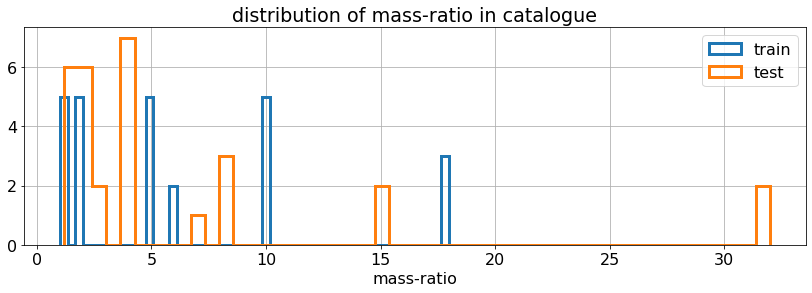

In [114]:
plt.figure(figsize=(14, 4))
plt.hist(data_dict['df']['q'][data_dict['train_idxs']], bins=50, histtype='step', lw=3, label='train')
plt.hist(data_dict['df']['q'][data_dict['test_idxs']], bins=50, histtype='step', lw=3, label='test')
plt.legend()
plt.xlabel("mass-ratio");
plt.title("distribution of mass-ratio in catalogue")
plt.grid()

In [115]:
waveforms = [
    workflow_utils.Waveform(
        strain=data_dict['strains'][i],
        times=data_dict['times'],
        amp=data_dict['amps'][i],
        phase=data_dict['phases'][i],
        freq=data_dict['freqs'][i],
        q=data_dict['df']['q'].values[i],
        meta_data=data_dict['df'].loc[[i]],
    )
    for i in range(len(data_dict['df']))]

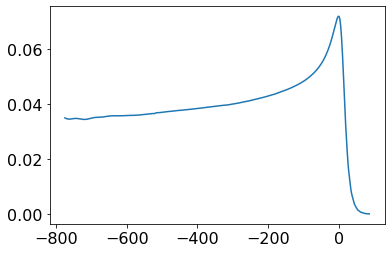

In [116]:
plt.plot(waveforms[0].times, waveforms[0].amp)

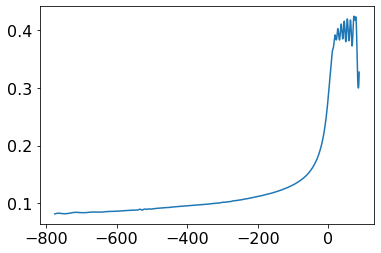

In [117]:
plt.plot(waveforms[0].times, waveforms[0].freq)

# Fit ansatz

In [118]:

# wcfs: Waveform Collocation Fitter objects
wcfs = []

for i in range(len(data_dict['df'])):
    q = data_dict['df'].iloc[i]['q']
    name = data_dict['df'].iloc[i]['name']
    set_member = data_dict['df'].iloc[i]['set']
    print(f"working: {i} ({set_member}): q={q} \t {name}")
    
    eta = phenom.eta_from_q(q)
    ang_fdamp = data_dict['df'].iloc[i]['fdamp']*2*np.pi
    
    # get data to fit
    t_, y_ = workflow_utils.prepare_fit_data(
        waveform=waveforms[i],
        t_start=t_start,
        t_end=t_end,
        target=target,
        dt=dt,
    )
    
    # apply tranformation
    # y_transformed = workflow_utils.transformation_affine_reverse(y_, eta)
    y_transformed = workflow_utils.transformation_affine_reverse(y_)
    
    # prepare ansatz
    ansatz = base_ansatz.copy()
    sub_dict = {"a_sym":ang_fdamp}
    
    wcf = workflow_utils.WaveformCollocationFitter(
        t_,
        y_transformed,
        collocation_points,
        ansatz,
        sub_dict,
    )

    wcfs.append(wcf)

working: 0 (train): q=18.0 	 q18a0a0c025_96_fine
working: 1 (test): q=4.0 	 q4a0_T_96_384
working: 2 (test): q=8.0 	 q8a0a0_T_96_504n512
working: 3 (test): q=8.0 	 q8a0a0c05_T_80_420
working: 4 (train): q=10.0 	 q10c25e_T_112_448
working: 5 (test): q=4.0 	 q4a0_T_80_320
working: 6 (train): q=18.0 	 q18a0a0c025_144
working: 7 (test): q=8.0 	 q8a0a0_T_112_588n768
working: 8 (train): q=18.0 	 q18a0a0c025_120
working: 9 (test): q=4.0 	 q4a0_T_112_448
working: 10 (train): q=5.0 	 SXS_BBH_0107_Res3
working: 11 (test): q=4.0 	 SXS_BBH_0167_Res5
working: 12 (train): q=5.0 	 SXS_BBH_0107_Res5
working: 13 (train): q=5.0 	 SXS_BBH_0107_Res4
working: 14 (test): q=4.0 	 SXS_BBH_0167_Res3
working: 15 (train): q=2.0 	 SXS_BBH_0169_Res4
working: 16 (train): q=2.0 	 SXS_BBH_0169_Res5
working: 17 (train): q=2.0 	 SXS_BBH_0169_Res3
working: 18 (train): q=1.0 	 SXS_BBH_0180_Res3
working: 19 (train): q=10.0 	 SXS_BBH_0303_Res3
working: 20 (train): q=1.0 	 SXS_BBH_0180_Res2
working: 21 (train): q=10.0 	 SXS

In [119]:
titles_ = []
y0s_ = []
y1s_ = []
pns_ = []
for i in range(len(data_dict['df'])):
    title_ = data_dict['df']['tag'][i]
    q = data_dict['df']['q'][i]
    eta = phenom.eta_from_q(q)
    # y0_ = workflow_utils.transformation_affine_foward(wcfs[i].y, eta)
    # y1_ = workflow_utils.transformation_affine_foward(wcfs[i].cm.predict(wcfs[i].x), eta)
    y0_ = workflow_utils.transformation_affine_foward(wcfs[i].y)
    y1_ = workflow_utils.transformation_affine_foward(wcfs[i].cm.predict(wcfs[i].x))
    
    titles_.append(title_)
    y0s_.append(y0_)
    y1s_.append(y1_)

y0s_ = np.array(y0s_)
y1s_ = np.array(y1s_)


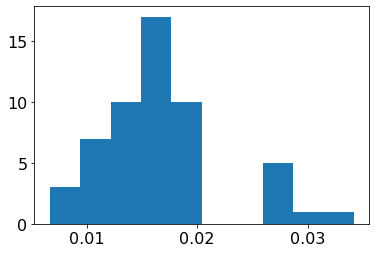

In [120]:
plt.hist(np.max(np.abs(y0s_ - y1s_), 1));

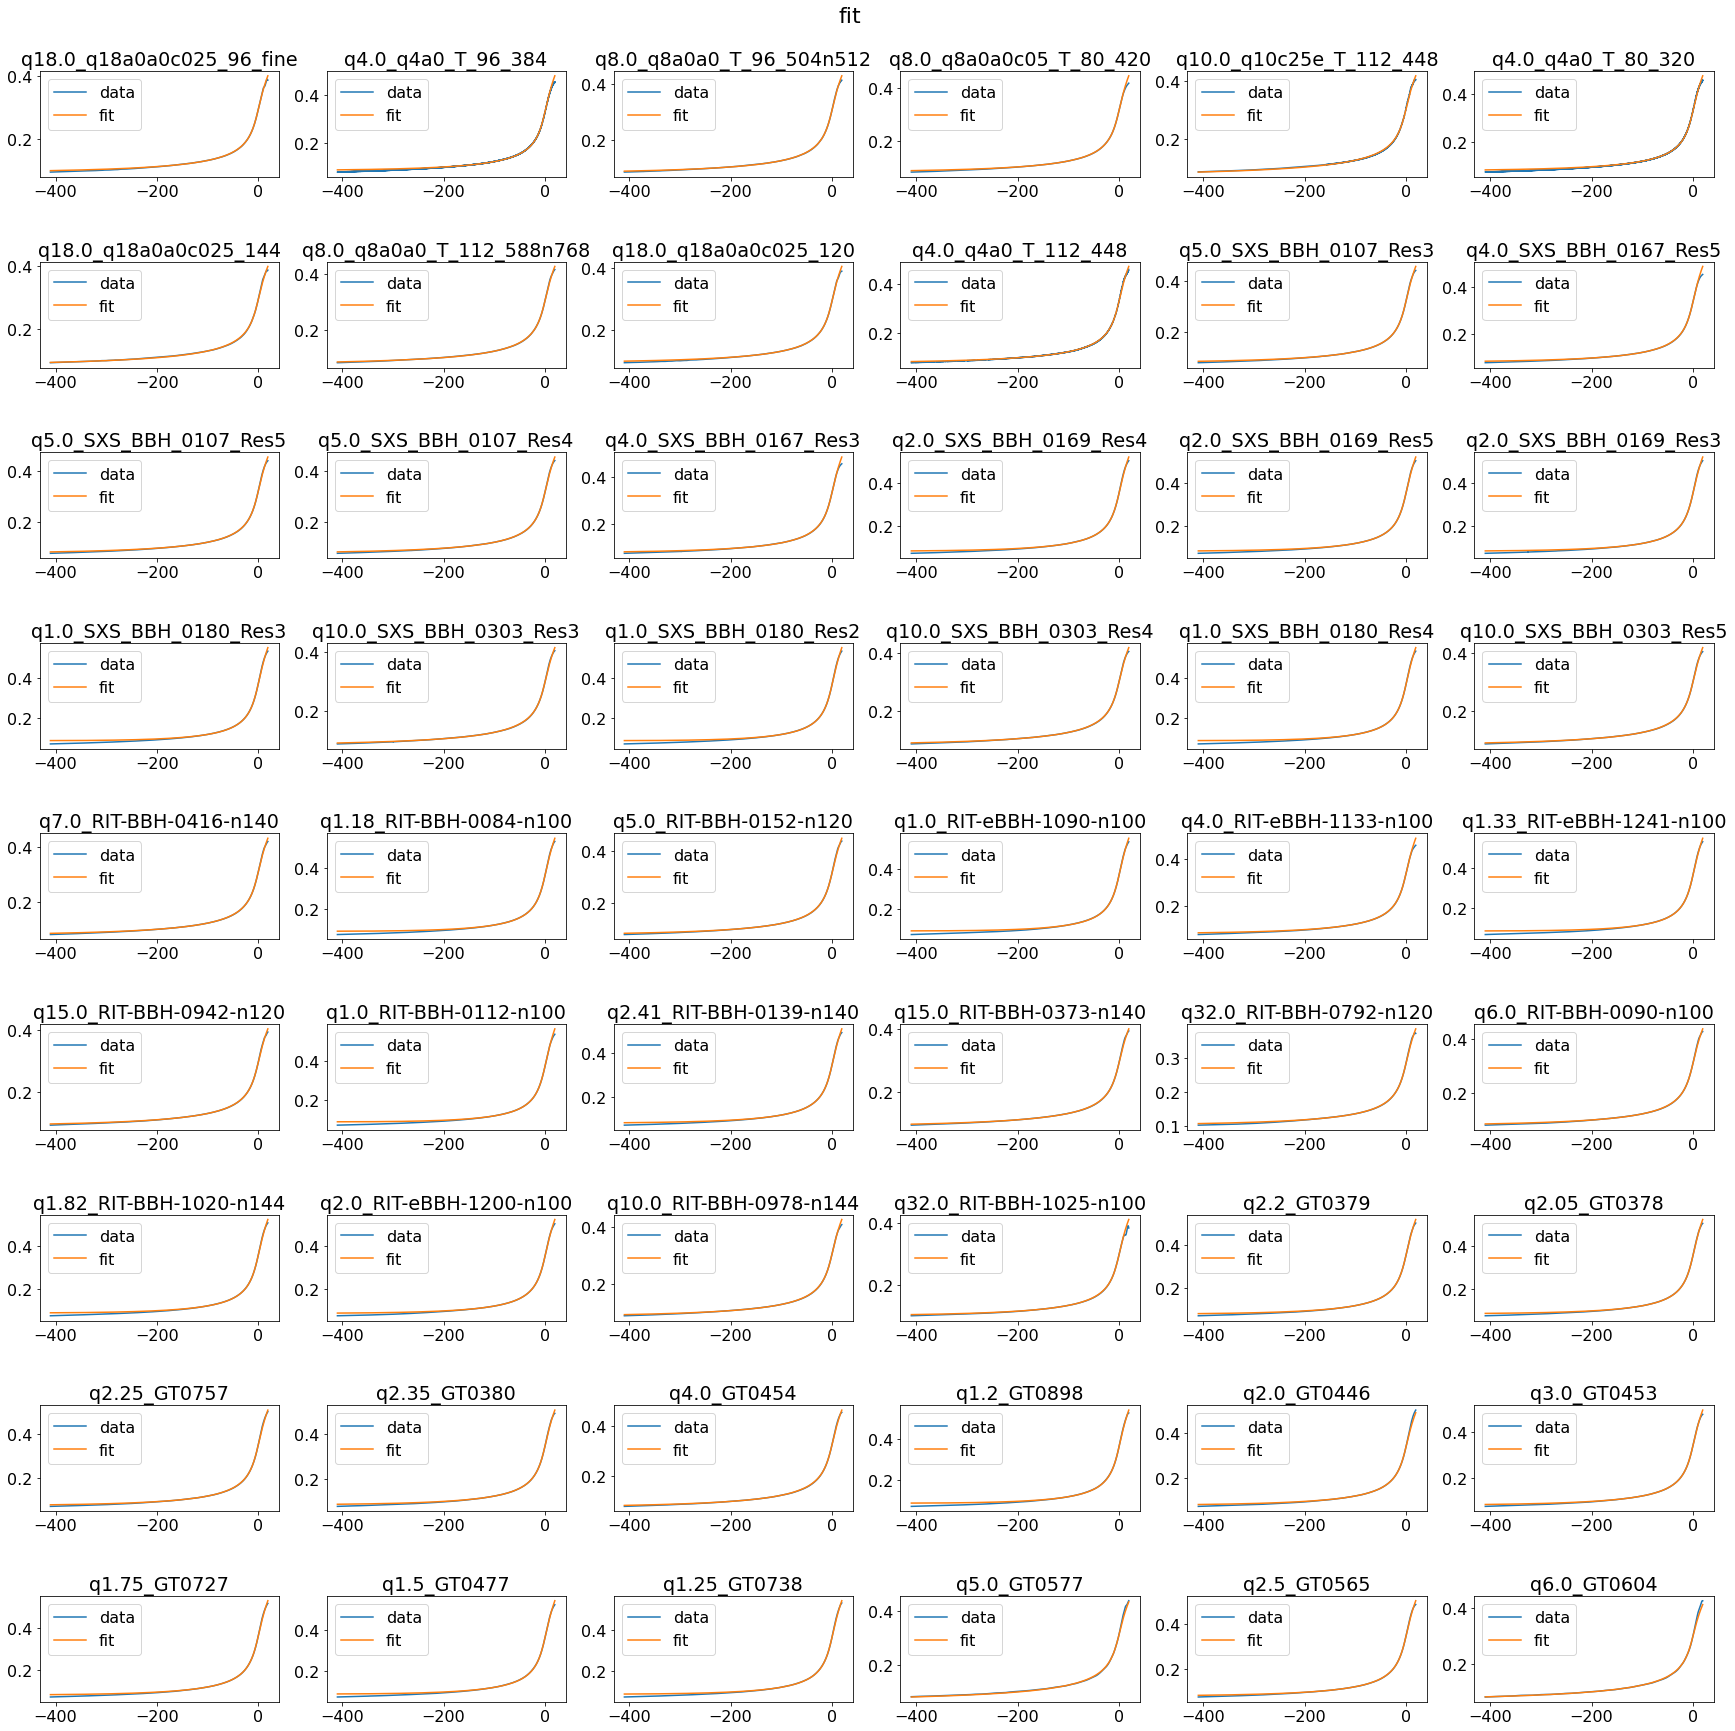

In [121]:
workflow_utils.plot_grid(xs=wcfs[0].x, ys=np.array([y0s_, y1s_]), ncols=6, figsize=(30, 30), titles=titles_, label=['data','fit'], suptitle="fit")

In [122]:
workflow_utils.plot_grid(xs=wcfs[0].x, ys=np.array([y0s_ - y1s_]), ncols=6, figsize=(30, 30), titles=titles_, label=['data-fit'], suptitle="Residuals")

# parameter space fits

## build train/test set for parameter space fits

In [123]:
# use these as the column names
# for the train/test set dataframes
# they correspond to the derivative-order
# and collocation point
tags = wcfs[0].cm.tags
tags

['d0_c0', 'd0_c1', 'd0_c2']

In [124]:
df_psf_x = data_dict['df']['q']

In [125]:
df_psf_y = pd.DataFrame(np.array([w.cm.rhs_1d for w in wcfs]), columns=tags)

In [126]:
df_psf_x_train = df_psf_x.iloc[data_dict['train_idxs']]
df_psf_y_train = df_psf_y.iloc[data_dict['train_idxs']]

In [127]:
df_psf_x_test = df_psf_x.iloc[data_dict['test_idxs']]
df_psf_y_test = df_psf_y.iloc[data_dict['test_idxs']]

In [128]:
# df_psf_xy_train = df_psf_y_train.copy()
# df_psf_xy_train['q'] = df_psf_x_train

# df_psf_xy_test = df_psf_y_test.copy()
# df_psf_xy_test['q'] = df_psf_x_test

# df_psf_xy_train.to_csv("dev_xy_train.csv", index=False)
# df_psf_xy_test.to_csv("dev_xy_test.csv", index=False)

In [129]:
df_psf_y

d0_c0     d0_c1     d0_c2
0   0.131895  0.224742  0.288409
1   0.122022  0.241169  0.326194
2   0.125990  0.231325  0.302861
3   0.126170  0.234227  0.309136
4   0.127446  0.230036  0.297650
5   0.122980  0.240288  0.322934
6   0.131623  0.225361  0.287887
7   0.125897  0.230083  0.300368
8   0.131720  0.224832  0.289019
9   0.122759  0.241428  0.323095
10  0.123047  0.236025  0.314306
11  0.122376  0.245486  0.332295
12  0.123100  0.235580  0.313392
13  0.123090  0.235289  0.312957
14  0.122436  0.243789  0.329012
15  0.119783  0.252023  0.347261
16  0.119811  0.252048  0.347297
17  0.119789  0.251948  0.347129
18  0.119195  0.257651  0.359725
19  0.127246  0.227395  0.295143
20  0.119193  0.257653  0.359716
21  0.127292  0.228037  0.296550
22  0.119196  0.257647  0.359735
23  0.127319  0.228390  0.297114
24  0.124737  0.230854  0.303435
25  0.119234  0.256302  0.357253
26  0.122841  0.234644  0.311655
27  0.119498  0.257470  0.359672
28  0.122491  0.244173  0.330115
29  0.119748  0.255453  0.355804
30  0.129909  0.224342  0.288658
31  0.119314  0.260800  0.365582
32  0.120134  0.247591  0.339241
33  0.129964  0.223963  0.287432
34  0.135393  0.220766  0.279781
35  0.124011  0.232142  0.306288
36  0.119767  0.252200  0.348700
37  0.119714  0.251766  0.347827
38  0.127181  0.229676  0.299888
39  0.135121  0.228369  0.293909
40  0.120840  0.251590  0.344738
41  0.120425  0.252306  0.346999
42  0.120754  0.249954  0.340502
43  0.121005  0.249584  0.340864
44  0.122860  0.240448  0.320723
45  0.119998  0.256692  0.356939
46  0.120049  0.244010  0.330530
47  0.121601  0.245748  0.333499
48  0.120432  0.254443  0.350377
49  0.120080  0.256700  0.356557
50  0.119962  0.256945  0.356303
51  0.123757  0.234937  0.307638
52  0.121066  0.249507  0.339907
53  0.124497  0.227693  0.294792

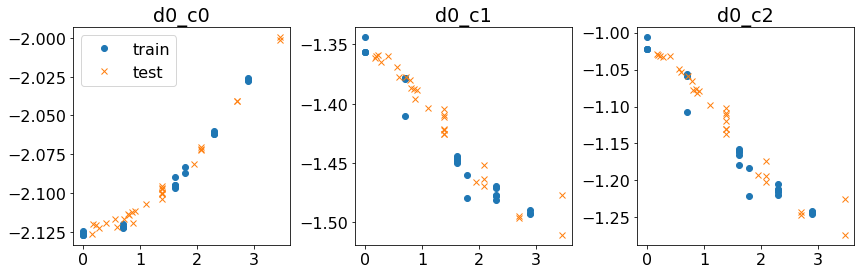

In [130]:
cols = df_psf_y_train.columns
ncols = len(cols)
nsamples = len(cols)
nrows = workflow_utils.get_nrows(ncols, nsamples)

plt.figure(figsize=(14, 4))
plt.subplots_adjust(hspace=0.8, wspace=0.3)
for i in range(nsamples):
    col = cols[i]
    ax = plt.subplot(nrows, ncols, i + 1)
    ax.plot(np.log(df_psf_x_train), np.log(df_psf_y_train[col]), 'o', label='train')
    ax.plot(np.log(df_psf_x_test), np.log(df_psf_y_test[col]), 'x', label='test')
    ax.set_title(col)
    if i == 0:
        ax.legend()

In [131]:
alphas = workflow_utils.compute_alphas(df_psf_x_train, df_psf_y_train)

In [132]:
alphas_test = workflow_utils.compute_alphas(df_psf_x_test, df_psf_y_test)

In [133]:
alphas

{'d0_c0': array([1.38031292e-04, 9.85150913e-05, 1.38031292e-04, 1.38031292e-04,
        3.45922663e-04, 3.45922663e-04, 3.45922663e-04, 1.28226306e-04,
        1.28226306e-04, 1.28226306e-04, 1.33033069e-04, 9.85150913e-05,
        1.33033069e-04, 9.85150913e-05, 1.33033069e-04, 9.85150913e-05,
        3.45922663e-04, 1.33033069e-04, 1.33033069e-04, 3.43612005e-04,
        1.28226306e-04, 9.85150913e-05, 1.28226306e-04, 3.45922663e-04,
        3.43612005e-04]),
 'd0_c1': array([0.0003346 , 0.00111526, 0.0003346 , 0.0003346 , 0.00053992,
        0.00053992, 0.00053992, 0.00355092, 0.00355092, 0.00355092,
        0.00143108, 0.00111526, 0.00143108, 0.00111526, 0.00143108,
        0.00111526, 0.00053992, 0.00143108, 0.00143108, 0.00314588,
        0.00355092, 0.00111526, 0.00355092, 0.00053992, 0.00314588]),
 'd0_c2': array([0.00056648, 0.00173667, 0.00056648, 0.00056648, 0.0026132 ,
        0.0026132 , 0.0026132 , 0.00753958, 0.00753958, 0.00753958,
        0.00262532, 0.00173667, 0.002

In [134]:
# we need to store the sign of the data so that
# we can reverse a log(abs(x)) transformation
signs_dict = df_psf_y_train.apply(lambda x: np.sign(x)).iloc[[0]]
signs_dict

d0_c0  d0_c1  d0_c2
0    1.0    1.0    1.0

In [135]:
alphas

{'d0_c0': array([1.38031292e-04, 9.85150913e-05, 1.38031292e-04, 1.38031292e-04,
        3.45922663e-04, 3.45922663e-04, 3.45922663e-04, 1.28226306e-04,
        1.28226306e-04, 1.28226306e-04, 1.33033069e-04, 9.85150913e-05,
        1.33033069e-04, 9.85150913e-05, 1.33033069e-04, 9.85150913e-05,
        3.45922663e-04, 1.33033069e-04, 1.33033069e-04, 3.43612005e-04,
        1.28226306e-04, 9.85150913e-05, 1.28226306e-04, 3.45922663e-04,
        3.43612005e-04]),
 'd0_c1': array([0.0003346 , 0.00111526, 0.0003346 , 0.0003346 , 0.00053992,
        0.00053992, 0.00053992, 0.00355092, 0.00355092, 0.00355092,
        0.00143108, 0.00111526, 0.00143108, 0.00111526, 0.00143108,
        0.00111526, 0.00053992, 0.00143108, 0.00143108, 0.00314588,
        0.00355092, 0.00111526, 0.00355092, 0.00053992, 0.00314588]),
 'd0_c2': array([0.00056648, 0.00173667, 0.00056648, 0.00056648, 0.0026132 ,
        0.0026132 , 0.0026132 , 0.00753958, 0.00753958, 0.00753958,
        0.00262532, 0.00173667, 0.002

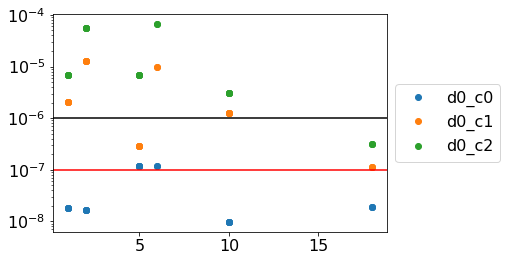

In [136]:
plt.figure()
for key in alphas.keys():
    plt.plot(df_psf_x_train, alphas[key]**2, 'o', label=key)
plt.axhline(1e-6, c='k')
plt.axhline(1e-7, c='r')
plt.yscale('log')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [137]:
plt.figure()
for key in alphas_test.keys():
    plt.plot(df_psf_x_test, alphas_test[key]**2, 'o', label=key)
plt.axhline(1e-6, c='k')
plt.axhline(1e-7, c='r')
plt.yscale('log')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('test')

Text(0.5, 1.0, 'test')

In [166]:
alpha_max = {}
# safety_factor = 1
safety_factor = 2
for k in alphas.keys():
    alpha_max[k] = alphas[k].max()**2 * safety_factor

In [167]:
alpha_max

{'d0_c0': 2.3932497750903403e-07,
 'd0_c1': 2.521808398737379e-05,
 'd0_c2': 0.00013216576154450807}

In [168]:
# loop over a fit
gps={}
for col in df_psf_y_train.columns:
    print(f"working: {col}")
    GaussianProcessRegressor_kwargs=dict(
        # kernel=Matern(nu=2.5) * ConstantKernel() + DotProduct() * ConstantKernel(),
        # kernel=Matern(nu=2.5)*ConstantKernel() + WhiteKernel(noise_level=1e-3, noise_level_bounds=(1e-10, 1)),
        kernel=Matern(nu=2.5)*ConstantKernel() + WhiteKernel(noise_level=alpha_max[col], noise_level_bounds=(0.99*alpha_max[col], 1.01*alpha_max[col])),
        # kernel=RBF(),
        # kernel=RBF() * ConstantKernel(),
        # kernel=Matern(nu=2.5),
        # kernel=Matern(nu=1.5),
        # kernel=Matern(nu=2.5) * ConstantKernel(),
        # alpha=alphas[col],
        # alpha=alphas[col]/8,
        # alpha=np.exp(1e-2),
        alpha=1e-10,
        # alpha=alpha_max[col],
        random_state=0,
        normalize_y=False,
        # normalize_y=True,
        n_restarts_optimizer=100,
        # optimizer=None
    )
    
    # transformations
    # x -> log(x)
    # y -> log(sign(y) * y)
    # for y we first enforce that the target is positive and then we take the log
    x=df_psf_x_train.apply(lambda x: np.log(x)).values
    y=df_psf_y_train[col].apply(lambda x: np.log(signs_dict[col].values * x)).values
    gp = workflow_utils.gpr_fit(
        x=x,
        y=y,
        GaussianProcessRegressor_kwargs=GaussianProcessRegressor_kwargs,
    )
    gps[col] = gp

working: d0_c0


/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 2.417182272841244e-07. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


working: d0_c1


/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 2.547026482724753e-05. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


working: d0_c2


/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 0.00013348741915995314. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


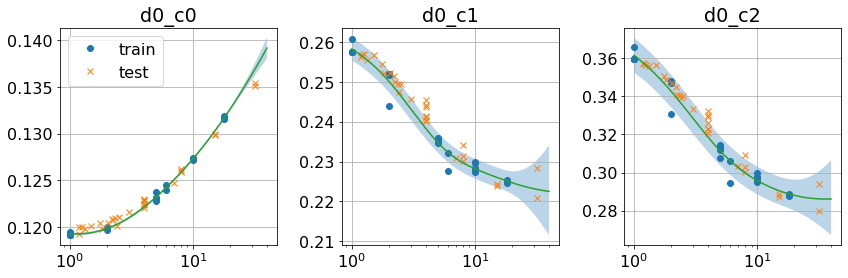

In [169]:
qs_fine = np.arange(1, 40, 0.2)[:,np.newaxis]
cols = df_psf_y_train.columns
ncols = len(cols)
nsamples = len(cols)
nrows = workflow_utils.get_nrows(ncols, nsamples)

plt.figure(figsize=(14, 4))
plt.subplots_adjust(hspace=0.8, wspace=0.3)
for i in range(nsamples):
    col = cols[i]
    gp = gps[col]
    
    # generate samples and reverse transformation
    mu_samples = gp.sample_y(np.log(qs_fine), n_samples=100, random_state=0)
    mu_samples = signs_dict[col].values * np.exp(mu_samples)
    mu_test, std_test = gp.predict(np.log(qs_fine), return_std=True)
    mu_test_lower = signs_dict[col].values * np.exp(mu_test-2*std_test)
    mu_test_upper = signs_dict[col].values * np.exp(mu_test+2*std_test)
    mu_test = signs_dict[col].values * np.exp(mu_test)
    
    ax = plt.subplot(nrows, ncols, i + 1)
    ax.plot(df_psf_x_train, df_psf_y_train[col], 'o', label='train')
    ax.plot(df_psf_x_test, df_psf_y_test[col], 'x', label='test')
    ax.plot(qs_fine, mu_test)
    # ax.plot(qs_fine, mu_samples, alpha=0.1, c='k')
    ax.fill_between(qs_fine[:,0], y1=mu_test_lower, y2=mu_test_upper, alpha=0.3)
    
    ax.set_title(col)
    if i == 0:
        ax.legend()
    # plt.axhline(1.5)
    # plt.axvline(32)
    # ax.set_ylim(0,3)
    ax.set_xscale('log')
    ax.grid()
    
plt.show()
plt.close()

In [170]:
gps['d0_c0'].kernel_

Matern(length_scale=20.7, nu=2.5) * 1.47**2 + WhiteKernel(noise_level=2.42e-07)

In [171]:
gps['d0_c0'].alpha_**2

array([2.30738538e+07, 1.98129914e+07, 1.40127922e+07, 4.89147766e+05,
       2.34464308e+07, 9.38744563e+06, 1.13824981e+07, 2.70720455e+06,
       4.53684720e+05, 2.03270590e+06, 8.20986432e+06, 4.18357043e+06,
       8.75820174e+06, 2.96650006e+05, 8.16907983e+06, 9.38800020e+04,
       1.38002184e+08, 5.82857528e+07, 1.58665178e+06, 2.71982887e+07,
       1.62515596e+07, 1.73678464e+07, 5.68044809e+07, 3.59148494e+08,
       1.20069057e+08])

In [172]:
alpha_max

{'d0_c0': 2.3932497750903403e-07,
 'd0_c1': 2.521808398737379e-05,
 'd0_c2': 0.00013216576154450807}

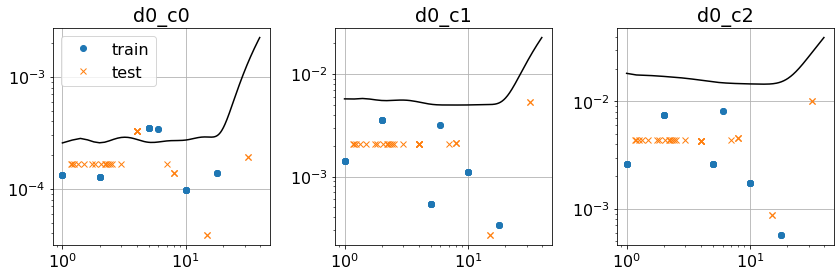

In [173]:
##### compare GPR variance with measured variance

qs_fine = np.arange(1, 40, 0.2)[:,np.newaxis]
cols = df_psf_y_train.columns
ncols = len(cols)
nsamples = len(cols)
nrows = workflow_utils.get_nrows(ncols, nsamples)

plt.figure(figsize=(14, 4))
plt.subplots_adjust(hspace=0.8, wspace=0.3)
for i in range(nsamples):
    col = cols[i]
    gp = gps[col]
    
    # generate samples and reverse transformation
    mu_samples = gp.sample_y(np.log(qs_fine), n_samples=100, random_state=0)
    mu_samples = signs_dict[col].values * np.exp(mu_samples)
    mu_test, std_test = gp.predict(np.log(qs_fine), return_std=True)
    mu_test_lower = signs_dict[col].values * np.exp(mu_test-2*std_test)
    mu_test_upper = signs_dict[col].values * np.exp(mu_test+2*std_test)
    mu_test = signs_dict[col].values * np.exp(mu_test)
    
    ax = plt.subplot(nrows, ncols, i + 1)
    ax.plot(df_psf_x_train, alphas[col], 'o', label='train')
    ax.plot(df_psf_x_test, alphas_test[col], 'x', label='test')
    ax.plot(qs_fine, (mu_test_upper-mu_test_lower), c='k')
    
    ax.set_title(col)
    if i == 0:
        ax.legend()
    # plt.axhline(1.5)
    # plt.axvline(32)
    # ax.set_ylim(0,3)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid()
    
plt.show()
plt.close()

#####

# model function

In [174]:
# generative phenomenological model (gpm)
def gpm_merger_omega_model(t, q, collocation_points, base_ansatz, gps, signs_dict, n_samples=-1, random_state=None):
    """
    if n_samples = -1 then generate the mean otherwise draw a n_samples
    """
    if random_state == None:
        random_state = np.random.randint(0, 1000000)
    if n_samples == -1:
        mode = "mean"
        n_samples = 1
    else:
        mode = "sample"
    
    t = np.atleast_1d(t)
    eta = phenom.eta_from_q(q)
    log_q = np.log(q)
    
    ang_fdamp = workflow_utils.get_fdamp_from_q(q)*2*np.pi
    
    sub_dict = {'a_sym':ang_fdamp}
    ansatz = base_ansatz.subs(sub_dict)
    
    # number of derivatives
    num_d_points = len(collocation_points.keys())
    # number of collocations points for each derivative
    num_c_points = [len(collocation_points[d]) for d in collocation_points.keys()]
    
    rhs = {}
    ## if mean then use the 'predict' method from the GP
    if mode == "mean":
        for d in range(num_d_points):
            rhs[d] = []
            for c in range(num_c_points[d]):
                tag = f"d{d}_c{c}"
                v = gps[tag].predict([[log_q]])
                v = np.exp(v)
                v = signs_dict[tag].values * v
                rhs[d].append(np.array([v]))
    ## if sample then use the 'sample_y' method from the GP
    elif mode == "sample":
        for d in range(num_d_points):
            rhs[d] = []
            for c in range(num_c_points[d]):
                tag = f"d{d}_c{c}"
                v = gps[tag].sample_y([[log_q]], n_samples, random_state=random_state)
                v = np.exp(v)
                v = signs_dict[tag].values * v
                rhs[d].append(v.T)
    else:
        raise ValueError(f"mode = {mode} unknown")

    # store a copy
    rhs_ = copy.deepcopy(rhs)
    
    yhats = []
    for n in range(n_samples):
        
        # have to extract the rhs for each sample
        for d in rhs_.keys():
            for i in range(len(rhs_[d])):
                rhs[d][i] = rhs_[d][i][n,0]
                
        cm = collocation.CollocationModel(
            collocation_points=collocation_points,
            rhs=rhs,
            ansatz=ansatz,
            sub_dict=None,
        )
        yhat = cm.predict(t)
        # yhat = workflow_utils.transformation_affine_foward(yhat, eta)
        yhat = workflow_utils.transformation_affine_foward(yhat)
        yhats.append(yhat)
    
    return np.array(yhats)

# model validation

In [175]:
ncols = 5
samples = data_dict['train_idxs']
nsamples = len(samples)
nrows = workflow_utils.get_nrows(ncols, nsamples)

plt.figure(figsize=(30, 20))
plt.subplots_adjust(hspace=0.8, wspace=0.3)
plt.suptitle("train", fontsize=22, y=0.91)
    
for i, idx in enumerate(samples):
    q_star = data_dict['df'].iloc[idx]['q']
    t_star = data_dict['times']
    mask = (t_star >= collocation_points[0][0]) & (t_star <= collocation_points[0][-1])
    t_star = t_star[mask]
    ynr = data_dict['freqs'][idx]
    ynr = ynr[mask]
    yhats = gpm_merger_omega_model(t_star, q_star, collocation_points, base_ansatz, gps, signs_dict, n_samples=-1)
    yhats_samples = gpm_merger_omega_model(t_star, q_star, collocation_points, base_ansatz, gps, signs_dict, n_samples=100)
    
    ydiff_samples = (ynr - yhats_samples)
    
    ax = plt.subplot(nrows, ncols, i + 1)
    # ax.plot(t_star, ynr-yhats[0], c='r')
    # ax.fill_between(t_star, y1=ydiff_samples.min(0), y2=ydiff_samples.max(0), color='k', alpha=0.3)
    # ax.axhline(0, c='C0')

    ax.plot(t_star, ynr)
    ax.plot(t_star, yhats[0], c='r')
    ax.fill_between(t_star, y1=yhats_samples.min(0), y2=yhats_samples.max(0), color='k', alpha=0.3)
    

    
    ax.set_title(data_dict['df'].iloc[idx]['tag'])
    
    # ax.set_ylim(-0.001, 0.001)

plt.show()
plt.close()

In [176]:
ncols = 5
samples = data_dict['test_idxs']
nsamples = len(samples)
nrows = workflow_utils.get_nrows(ncols, nsamples)

plt.figure(figsize=(30, 20))
plt.subplots_adjust(hspace=0.8, wspace=0.3)
plt.suptitle("test", fontsize=22, y=0.91)

for i, idx in enumerate(samples):
    q_star = data_dict['df'].iloc[idx]['q']
    t_star = data_dict['times']
    mask = (t_star >= collocation_points[0][0]) & (t_star <= collocation_points[0][-1])
    t_star = t_star[mask]
    ynr = data_dict['freqs'][idx]
    ynr = ynr[mask]
    yhats = gpm_merger_omega_model(t_star, q_star, collocation_points, base_ansatz, gps, signs_dict, n_samples=-1)
    yhats_samples = gpm_merger_omega_model(t_star, q_star, collocation_points, base_ansatz, gps, signs_dict, n_samples=100)
    
    ydiff_samples = (ynr - yhats_samples)
    
    ax = plt.subplot(nrows, ncols, i + 1)
    # ax.plot(t_star, ynr-yhats[0], c='r')
    # ax.fill_between(t_star, y1=ydiff_samples.min(0), y2=ydiff_samples.max(0), color='k', alpha=0.3)
    # ax.axhline(0, c='C0')
    
    ax.plot(t_star, ynr)
    ax.plot(t_star, yhats[0], c='r')
    ax.fill_between(t_star, y1=yhats_samples.min(0), y2=yhats_samples.max(0), color='k', alpha=0.3)
    
    ax.set_title(data_dict['df'].iloc[idx]['tag'])
    
    # ax.set_ylim(-0.001, 0.001)
plt.show()
plt.close()

# save model

In [177]:
components_to_save = {
    "collocation_points":collocation_points,
    "base_ansatz":base_ansatz,
    "gps":gps,
    "signs_dict":signs_dict,
}

In [178]:
output_filename = os.path.join(OUTPUT_PATH, 'components.cpkl')

In [179]:
output_filename

'/Users/sebastian.khan/personal/data/gpm_model/freq_merger_11_09_23/components.cpkl'

In [180]:
with open(output_filename, "wb") as f:
    cloudpickle.dump(components_to_save, f)

In [181]:
# with open(output_filename, 'rb') as f:
#     test_c = cloudpickle.load(f)

In [182]:
# test_c.keys()

In [183]:
# collocation_points = test_c["collocation_points"]
# base_ansatz = test_c["base_ansatz"]
# gps = test_c["gps"]
# signs_dict = test_c["signs_dict"]

In [184]:
data_dict['df'].query('q==18')

name     q     fring    fdamp  duration  t_final  \
0  q18a0a0c025_96_fine  18.0  0.063334  0.01414    1020.0    465.8   
6      q18a0a0c025_144  18.0  0.063334  0.01414    1028.3     88.8   
8      q18a0a0c025_120  18.0  0.063334  0.01414    1027.5    174.7   

   start_freq_100Msun    set  has_dup                        tag  
0           26.412409  train     True  q18.0_q18a0a0c025_96_fine  
6           26.822393  train     True      q18.0_q18a0a0c025_144  
8           26.803431  train     True      q18.0_q18a0a0c025_120

In [185]:
collocation_points

{0: [-100, -12, 0]}

In [186]:
# t_star = np.arange(-300, 0, 1)
t_star = np.arange(-100, 0, 1)
# q_star = 32

idx = 34
# idx = 8
# idx = 22
# idx = 7
# idx = 33
q_star = data_dict['df']['q'][idx]

In [187]:
q_star

32.0

In [188]:
yhats = gpm_merger_omega_model(t_star, q_star, collocation_points, base_ansatz, gps, signs_dict, n_samples=-1)
yhats_samples = gpm_merger_omega_model(t_star, q_star, collocation_points, base_ansatz, gps, signs_dict, n_samples=100)

In [189]:
yhats.shape

(1, 100)

In [190]:
data_dict['df'].iloc[idx]['q']

32.0

In [191]:
t_start

-410

In [192]:
collocation_points

{0: [-100, -12, 0]}

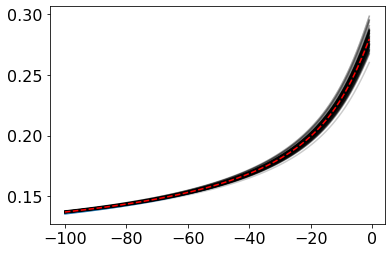

In [193]:
mask = (waveforms[idx].times > t_star[0]) & (waveforms[idx].times < t_star[-1])
plt.plot(waveforms[idx].times[mask], waveforms[idx].freq[mask], label='data')

plt.plot(t_star, yhats_samples.T, c='k', alpha=0.2);
plt.plot(t_star, yhats[0], c='r', ls='--')



# plt.yscale('log')
# plt.xlim(-800, -100)
# plt.ylim(0.05, 0.3)